<a href="https://colab.research.google.com/github/llorenzo62/Entropy/blob/master/permutation_entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

[Karsten Keller. Entropy_Measures_for_Data_Analysis. Entropy 2019, 21, 935, doi:10.3390/e21100935](https://www.mdpi.com/books/pdfview/book/1906)


Starting with the definition Permutation Entropy [PE] from [David Cuesta-Frau, Juan Pablo Murillo-Escobar, Diana Alexandra Orrego and Edilson Delgado-Trejos. Embedded  Dimension and Time Series Length. Practical Influence on Permutation Entropy and Its Applications Entropy  2019, 21, 385; doi:10.3390/e21040385](https://www.mdpi.com/books/pdfview/book/1906)

> 
2.1. Permutation Entropy
    Given an input time series $\{ x t : t = 0, ... , N − 1 \}$ , and an embedding dimension $m > 1$, for each extracted subsequence at time $s, ( s ) \leftarrow x_{s −( m − 1 )} , x_{s −( m − 2 )} , ..., x_{s − 1} , x_{s}$ , an ordinal pattern π related to s is obtained as $\pi = ( r_0 , r_1 , ..., r_{m − 1} )$ , defined by $x_{s − r_{m − 1}} ≤ x_{ s − r_{ m − 2}} ≤ . . . ≤ x_{ s − r_1} ≤ x_{ s − r_{ 0}}$ [15]. For all the possible $m!$ permutations, each probability $p ( π )$ is estimated as the relative frequency of each different $π$ pattern found. Once all these probabilities have been obtained, the final value of PE is given by [11]:   $$PE = -\sum_{j=0}^{m!-1}{p(\pi_j)\log(p(\pi_j))}, \text{ if } p(\pi_j)>0$$
   
>    
More details of the PE algorithm, including examples, can be found in [11]. The implicit input
parameters for PE are:
   * The embedded dimension m. The recommended range for this parameter is 3, . . . , 7 [11], but other greater values have been used successfully [12,24,26,27]. 
   * The embedded delay τ. The influence of the embedded delay has been studied in several previous publications [10,29] for specific applications .... this parameter contributes to a reduction in the amount of data available when τ > 1 in practical terms [30], and therefore might have a detrimental effect on the analysis. 
   * The length of the time series N. As stated before, the recommended relationship m! << N is commonplace in practically all the publications related to PE, ....


_python3_ allows a especially concise implementation of PE

In [ ]:
def PE(serie,m,tau=1,okfr=False):
    freq={}
    if tau==1:
        for index in range(m,len(serie)):
            #encoding
            s={val:indx for indx,val in enumerate(sorted(serie[index-m:index]))}
            key=tuple(s[item] for item in serie[index-m:index])
            #counting
            freq[key]=freq.get(key,0)+1


        
    else:
        for t in range(tau):
            ser=serie[t::tau]
            #print((ser))
            _,fr=PE(list(ser),m,okfr=True)
            for key,val in fr.items():
                freq[key]=freq.get(key,0)+val
    
    f=np.array(list(freq.values()))

    f=f/f.sum()
    if okfr:
        return (-f*np.log(f)).sum(), freq
    return (-f*np.log(f)).sum()   

## Simulations

### sinthetic time series  

_Lorenz_ from   Teddy Craciunescu, Andrea Murari and Michela Gelfusa. Entropy 2018, 20, 891; doi:10.3390/e20110891  
_LMS_ from Albert B. Piek, Inga Stolz and Karsten Keller Entropy 2019, 21, 547; doi:10.3390/e21060547


In [ ]:
def LMS(n,p=8):
    a=np.random.random()
    a=np.ceil(2**p*a)*2**(-p)
    L=[np.sin(2*np.pi*a)]
    for _ in range(n):
        b=np.random.uniform(0.5,7)
        a=(2*a % 1)+b*2**(-p)
        L.append(np.sin(2*np.pi*a))
    return L

def Lorenz(v,dt=0.01,C=2):
    x1,x2,x3,y1,y2,y3=v
    
    dx1=10*(x2-x1)
    dx2=x1*(28-x3)-x2
    dx3=x1*x2-8*x3/3
    dy1=10*(y2-y1)
    dy2=y1*(28.001-y3)-y2
    dy3=y1*y2-8*y3/3+C*(x3-y3)
    
    return [x1+dx1*dt, x2+dx2*dt, x3+dx3*dt, y1+dy1*dt, y2+dy2*dt, y3+dy3*dt]
        

N=1000000
series=[np.random.normal(0,1,N)]


#sin waves
from random import sample

p=np.array([7,11])#vector with periods for sin wave
c=np.array([2,2])#vector with coefficients for sin wave
c0=1.0 #random error coeff.
lp=[]
for i in range(N):
    lp.append((c*np.sin(np.pi*2*i/p)).sum()+c0*(np.random.normal()-0.5))
series.append(lp)

p=np.array([7,11])#vector with periods for sin wave
c=np.array([2,2])#vector with coefficients for sin wave
c0=0.0
lp=[]
for i in range(N):
    lp.append((c*np.sin(np.pi*2*i/p)).sum()+c0*(np.random.normal()-0.5))
series.append(lp)


'''lp=[]
v=np.random.random(6)
for i in range(N):
    v=Lorenz(v)
    
    lp.append(v[0])
series.append(lp)
'''

series.append(LMS(N,12))
series.append(LMS(N,120))

name_serie=['uniform','sin7_11_e','sin7_11','LMS12','LMS120']

Let define _simulation(series,name_serie,rN,rm,rb)_ where:
* series: a list of time series generated as above.
* name_serie: string identify each time serie
* rN: list with N values to be tested
* rm: list with m values to be tested
* rb: list with $\tau$ values to be tested  

This function returns a _pandas.DataFrame_ with the columns:
* serie: string identify the time serie
* N: len(time serie)
* b: $\tau$ value used in $PE_{m,\tau}$
* m: m value used in $PE_{m,\tau}$
* PE: $PE_{m,\tau}(time serie)$
* N/m!
* H or PE_r: $\log(m!)-PE_{m,\tau}$
* t: Runtime in seconds


In [ ]:
def simulation(series,name_serie,rN,rm,rb):
    
    import time
    import pandas as pd
    
    res=[]
    for nn in rN:
        for name,serie in zip(name_serie,series):
            serie=serie[:int(round(nn))]
            for m in rm:
                for b in rb:
                    time0=time.time()
                    res.append((name,len(serie),b,m,PE(serie,m,b),len(serie)/np.math.factorial(m),time.time()-time0))

        print(res[-1])
    res_m=np.array(res)
    lms=pd.DataFrame(res_m,columns=['serie','N','b','m','PE','N/m!','t'])
    lms['b']=lms['b'].astype(np.integer)
    lms['m']=lms['m'].astype(np.integer)
    lms['PE']=lms['PE'].astype(np.float)
    lms['N/m!']=lms['N/m!'].astype(np.float)
    lms['t']=lms['t'].astype(np.float)
    lms['H']=np.log(lms['m'].apply(np.math.factorial))-lms['PE']
    lms['N']=(lms['N']).astype(np.integer)
    return lms

exper2_b=simulation(series,name_serie,[1e6],[5],range(1,1000,2))

ts=np.exp(np.linalg.linspace(np.log(100),np.log(N),50))
exper2_Nmb=simulation(series,name_serie,ts,range(3,13),range(1,9))

import pickle
with open('exper2_b.pkl','wb') as fich:
    pickle.dump(exper2_b,fich)

In [ ]:
import pickle
with open('exper2_Nmb.pkl','rb') as fich:
    lms = pickle.load(fich)


## Runtime  

$N$, $m$ and $\tau$ effect  on $PE_{m,\tau}(serie)$ runtime 



In [ ]:
lms.describe()

,b,m,PE,N/m!,t,PE_r,N
count,22500.000000,22500.000000,22500.000000,2.250000e+04,22500.000000,2.250000e+04,22500.000000
mean,5.000000,7.500000,5.388000,2.547472e+03,0.274748,4.698209e+00,116705.602000
std,2.582046,2.872345,2.977471,1.350371e+04,0.570746,4.766815e+00,224071.929156
min,1.000000,3.000000,0.000000,2.087676e-07,0.000077,2.501121e-07,100.000000
25%,3.000000,5.000000,3.169916,2.596438e-03,0.002098,3.900299e-01,954.000000
50%,5.000000,7.500000,4.403803,6.611855e-01,0.021908,3.148286e+00,10044.000000
75%,7.000000,10.000000,7.165307,6.894479e+01,0.226301,8.206708e+00,104811.000000
max,9.000000,12.000000,13.814095,1.666667e+05,6.385526,1.998721e+01,1000000.000000


In [ ]:
lms.serie.unique()

array(['uniform', 'sin7_11_e', 'sin7_11', 'LMS12', 'LMS120'], dtype=object)

In [ ]:
from sklearn.linear_model import LinearRegression

model=LinearRegression()

In [ ]:
def select(sec,data):
    res=data.copy()
    for col,cond in sec:
        res=res[res[col] == cond]
    return res
        

### Runtime vs. N

<IPython.core.display.Javascript object>


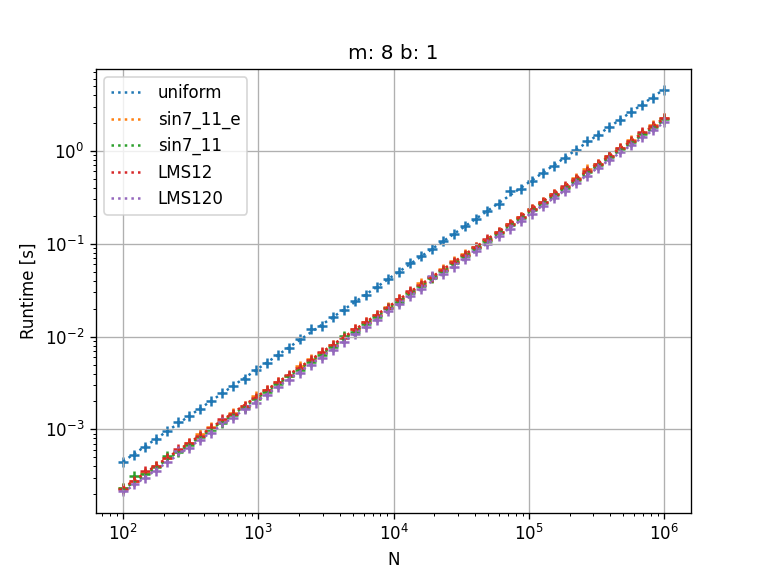

uniform; score: 0.9999279877058167
	 log(Runtime) [s]= [1.00239011] log(N) + -12.320855265784239
sin7_11_e; score: 0.9999694350359711
	 log(Runtime) [s]= [0.99653033] log(N) + -12.956090747935077
sin7_11; score: 0.9998849471073258
	 log(Runtime) [s]= [0.99546844] log(N) + -12.98309334323095
LMS12; score: 0.9999575522210615
	 log(Runtime) [s]= [0.99509112] log(N) + -12.946041112437968
LMS120; score: 0.9998884716982966
	 log(Runtime) [s]= [0.99582466] log(N) + -13.0582555342994


In [ ]:
for serie in lms.serie.unique():
    m=8
    b=1
    sec=select([('serie',serie),('m',m),('b',b)],lms)
    
    X=sec['N'].apply(np.log)
    y=sec['t'].apply(np.log)
    #color=['red','green','blue'][int(m/4)-1]
    model.fit(np.array(X).reshape(-1,1),y)
    plt.plot(np.exp(X),np.exp(model.predict(np.array(X).reshape(-1,1))),linestyle='dotted')
    plt.scatter(np.exp(X),np.exp(y),marker='+')
    print('{}; score: {}\n\t log(Runtime) [s]= {} log(N) + {}'.format(serie,model.score(np.array(X).reshape(-1,1),y)
                                                ,model.coef_,model.intercept_))
plt.xlabel('N')
plt.xscale('log')
plt.ylabel('Runtime [s]')
plt.yscale('log')
plt.legend(lms.serie.unique())
plt.title('m: {} b: {}'.format(m,b))

plt.grid()

plt.show()


There is no explanation for _uniform_ anomaly

### Runtime vs m

<IPython.core.display.Javascript object>


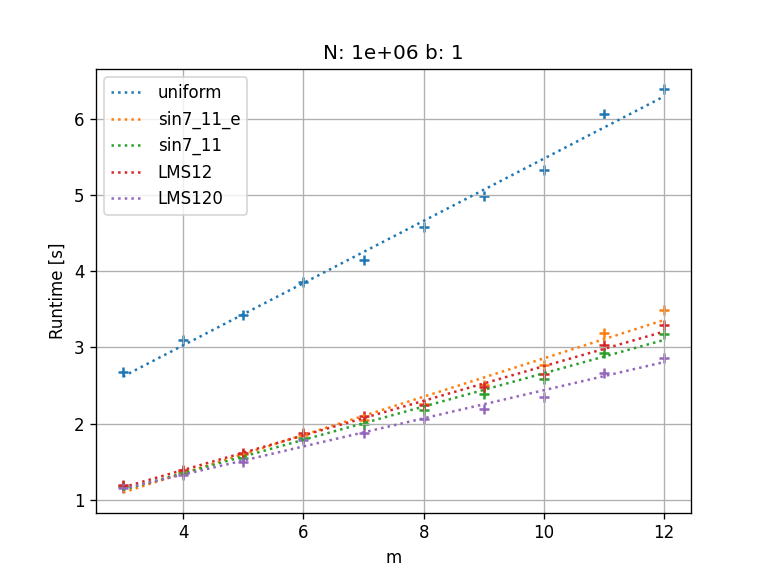

uniform; score: 0.9932305709587471
	 Runtime [s]= [0.40808912] m + 1.3954178983514964
sin7_11_e; score: 0.9888188863988774
	 Runtime [s]= [0.25126615] m + 0.34454945650967694
sin7_11; score: 0.9941176424057409
	 Runtime [s]= [0.2183821] m + 0.47822532220320224
LMS12; score: 0.9929572920767263
	 Runtime [s]= [0.22695347] m + 0.48514927517284057
LMS120; score: 0.9910391925539237
	 Runtime [s]= [0.18441204] m + 0.5954226320440119


In [ ]:
for serie in lms.serie.unique():
   
    b=1
    sec=select([('serie',serie),('b',b)],lms)
    sec=sec[sec['N']>9.9e5]
    X=sec['m']
    y=sec['t']
    #color=['red','green','blue'][int(m/4)-1]
    model.fit(np.array(X).reshape(-1,1),y)
    plt.plot((X),(model.predict(np.array(X).reshape(-1,1))),linestyle='dotted')
    plt.scatter((X),(y),marker='+')
    print('{}; score: {}\n\t Runtime [s]= {} m + {}'.format(serie,model.score(np.array(X).reshape(-1,1),y)
                                                ,model.coef_,model.intercept_))
plt.xlabel('m')
#plt.xscale('log')
plt.ylabel('Runtime [s]')
#plt.yscale('log')
plt.legend(lms.serie.unique())
plt.title('N: {:g} b: {}'.format(sec.N.max(),b))

plt.grid()

plt.show()


### Runtime vs $\tau$

<IPython.core.display.Javascript object>


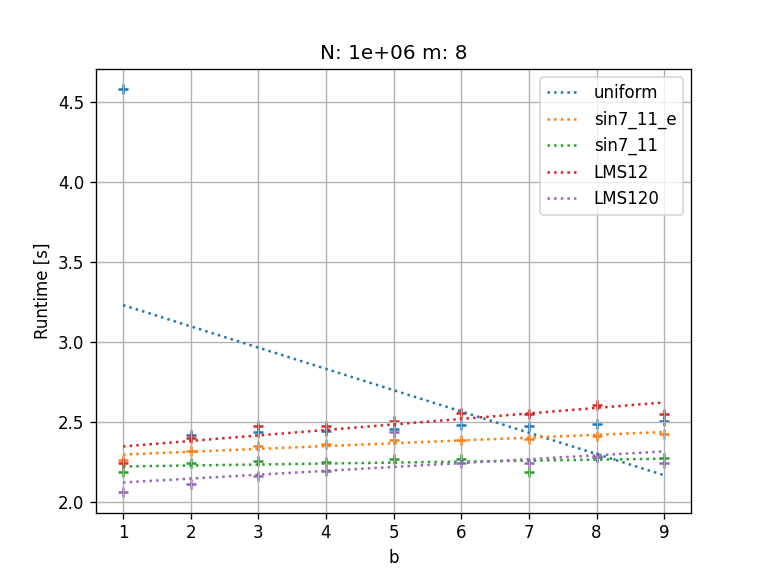

uniform; score: 0.26613944356119557
	 Runtime [s]= [-0.13305118] b + 3.3643865982691445
sin7_11_e; score: 0.8898984999187045
	 Runtime [s]= [0.01764335] b + 2.278806169827779
sin7_11; score: 0.21714446009908905
	 Runtime [s]= [0.0060464] b + 2.2160823808776007
LMS12; score: 0.758193669178103
	 Runtime [s]= [0.03445176] b + 2.3125515315267773
LMS120; score: 0.3728794311420689
	 Runtime [s]= [0.02428504] b + 2.0974786678949995


In [ ]:
for serie in lms.serie.unique():
   
    m=8
    sec=select([('serie',serie),('m',m)],lms)
    sec=sec[sec['N']>9.9e5]
    X=sec['b']
    y=sec['t']
    #color=['red','green','blue'][int(m/4)-1]
    model.fit(np.array(X).reshape(-1,1),y)
    plt.plot((X),(model.predict(np.array(X).reshape(-1,1))),linestyle='dotted')
    plt.scatter((X),(y),marker='+')
    print('{}; score: {}\n\t Runtime [s]= {} b + {}'.format(serie,
                                                                      model.score(np.array(X).reshape(-1,1),y)
                                                                    ,model.coef_,model.intercept_))
plt.xlabel('b')
#plt.xscale('log')
plt.ylabel('Runtime [s]')
#plt.yscale('log')
plt.legend(lms.serie.unique())
plt.title('N: {:g} m: {}'.format(sec.N.max(),m))

plt.grid()

plt.show()


And there is no explanation for _uniform_ anomaly.  
How good estimations are could be seen in a $PE_{m,\tau}$ vs. $\log(\frac{N}{m!})$ graph for uniform. The expected value of $PE_{m,\tau} = \log(m!)$ for each $m$ value is represented as a dotted segment

<IPython.core.display.Javascript object>


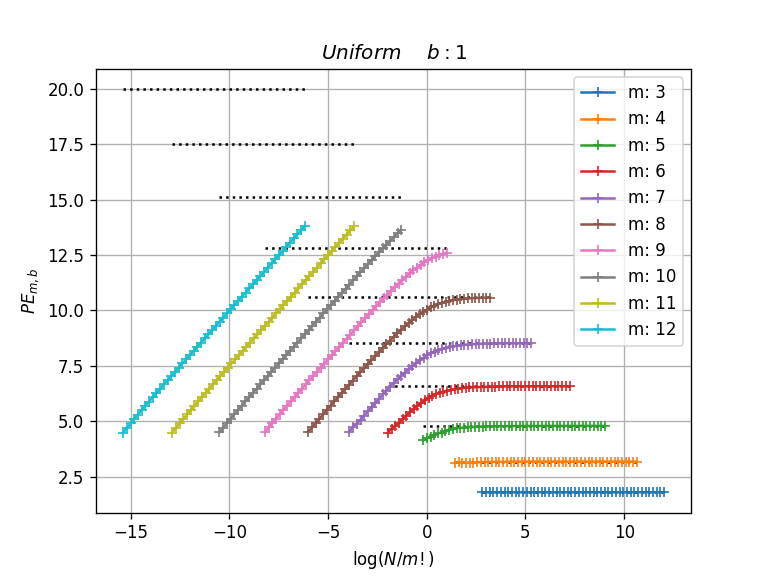

In [ ]:

for m in range(round(lms.m.min()),round(lms.m.max())+1):
   
    
    sec=select([('serie','uniform'),('b',1),('m',m)],lms)
    
    X=sec['N/m!'].apply(np.log)
    y=sec['PE']
    #color=['red','green','blue'][int(m/4)-1]
    
    plt.plot((X),(y),marker='+')
    plt.hlines(np.log(np.math.factorial(m)),X.min(),X.max(), linestyles='dotted')
    
plt.xlabel('$\log(N/m!)$')
#plt.xscale('log')
plt.ylabel('$PE_{m,b}$')
#plt.yscale('log')
plt.legend(['m: {}'.format(item) for item in range(round(lms.m.min()),round(lms.m.max())+1)])
plt.title('$ Uniform ~~~~   b: %i $' % b)

plt.grid()

plt.show()




It is clear that $\log(\frac{N}{m!})>0$ for a reliable estimation. 

If we represent the estimation relative error, computed as $\frac{\log(m!)-PE_{m,\tau}}{PE_{m,\tau}}$ v.s.  $\log(\frac{N}{m!})$ we could see that $N \approx m!$ corresponds to a relative error $\frac{\log(m!)-PE_{m,\tau}}{PE_{m,\tau}} \approx 10\%$. The red dotted line represents this 10% relative error.

<IPython.core.display.Javascript object>


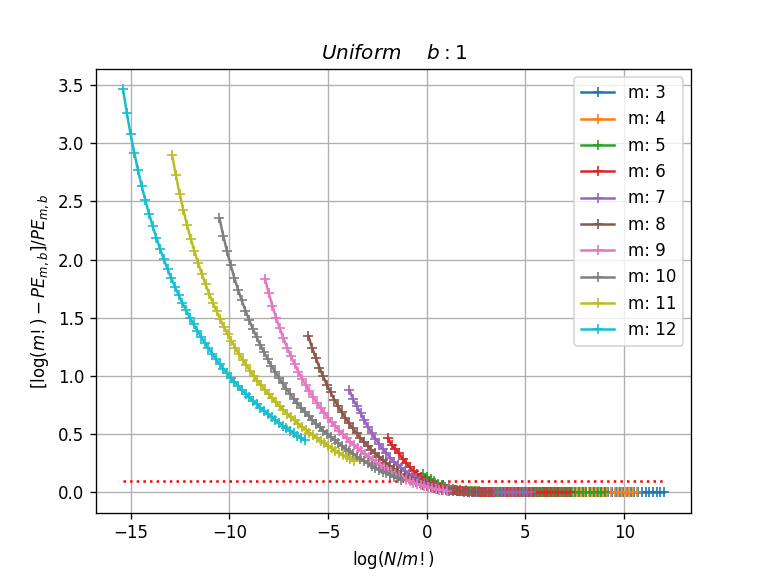

In [ ]:
mn=float('inf')
mx=-float('inf')
for m in range(round(lms.m.min()),round(lms.m.max())+1):
   
    
    sec=select([('serie','uniform'),('b',1),('m',m)],lms)
    
    X=sec['N/m!'].apply(np.log)
    mn=min(mn,X.min())
    mx=max(mx,X.max())
    y=sec['PE_r']/sec['PE']
    #color=['red','green','blue'][int(m/4)-1]
    
    plt.plot((X),(y),marker='+')
    

plt.hlines(0.1,mn,mx, linestyles='dotted',color='red')
plt.xlabel('$\log(N/m!)$')
#plt.xscale('log')
plt.ylabel('$[\log(m!)-PE_{m,b}]/PE_{m,b}$')
#plt.yscale('log')
plt.legend(['m: {}'.format(item) for item in range(round(lms.m.min()),round(lms.m.max())+1)])
plt.title('$ Uniform ~~~~   b: %i $' % b)

plt.grid()

plt.show()




A _delay_ operation on serie $S_N=\{ s_0, ..., s_N\}$ splits it in $\tau$ series of length $\frac{N}{\tau}$,  $\sigma_i=\{s_i,s_{i+\tau},s_{i+2\tau}..., s_{i+\frac{N}{\tau}}\}$. Define a new time serie $S_{N,\tau}=\cup_{i=0}^{\tau-1}\sigma_i$ and then we could define the $PE$ with dimension $m$ and delay $\tau$ on $S_N$ as $$PE_{m,\tau}(S_N) \equiv PE_{m,1}(S_{N,\tau})$$  



<IPython.core.display.Javascript object>


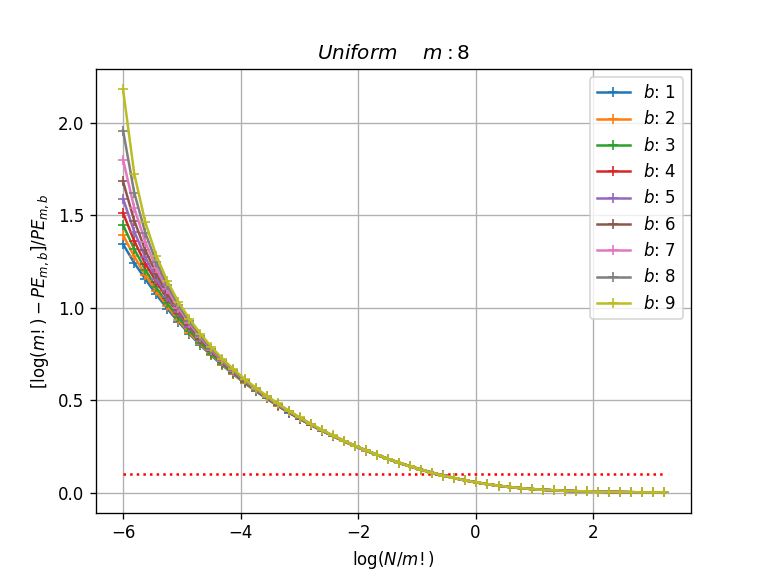

In [ ]:
mn=float('inf')
mx=-float('inf')
m=8
for b in range(round(lms.b.min()),round(lms.b.max())+1):
   
    
    sec=select([('serie','uniform'),('b',b),('m',8)],lms)
    
    X=sec['N/m!'].apply(np.log)
    mn=min(mn,X.min())
    mx=max(mx,X.max())
    y=sec['PE_r']/sec['PE']
    #color=['red','green','blue'][int(m/4)-1]
    
    plt.plot((X),(y),marker='+')
    

plt.hlines(0.1,mn,mx, linestyles='dotted',color='red')
plt.xlabel('$\log(N/m!)$')
#plt.xscale('log')
plt.ylabel('$[\log(m!)-PE_{m,b}]/PE_{m,b}$')
#plt.yscale('log')
plt.legend(['$b$: {}'.format(item) for item in range(round(lms.b.min()),round(lms.b.max())+1)])
plt.title('$ Uniform ~~~~   m: %i $' % m)

plt.grid()

plt.show()




<IPython.core.display.Javascript object>


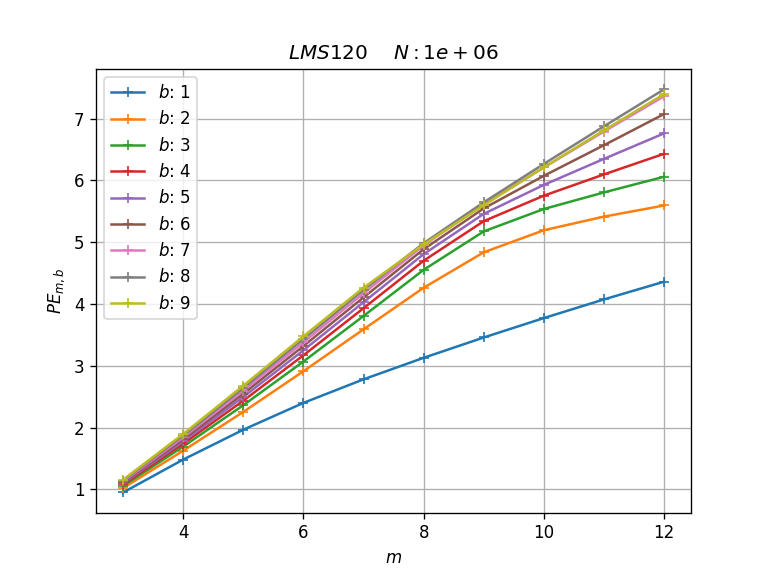

In [ ]:
mn=float('inf')
mx=-float('inf')
serie=name_serie[4]
for b in range(round(lms.b.min()),round(lms.b.max())+1):
   
    
    sec=select([('serie',serie),('b',b)],lms)
    sec=sec[sec['N']>9.9e5]
    X=sec['m']
    mn=min(mn,X.min())
    mx=max(mx,X.max())
    y=sec['PE']
    #color=['red','green','blue'][int(m/4)-1]
    
    plt.plot((X),(y),marker='+')
    


plt.xlabel('$m$')
#plt.xscale('log')
plt.ylabel('$PE_{m,b}$')
#plt.yscale('log')
plt.legend(['$b$: {}'.format(item) for item in range(round(lms.b.min()),round(lms.b.max())+1)])
plt.title('$ %s ~~~~   N: %g $' % (serie,round(sec['N'].max())))

plt.grid()

plt.show()




<IPython.core.display.Javascript object>


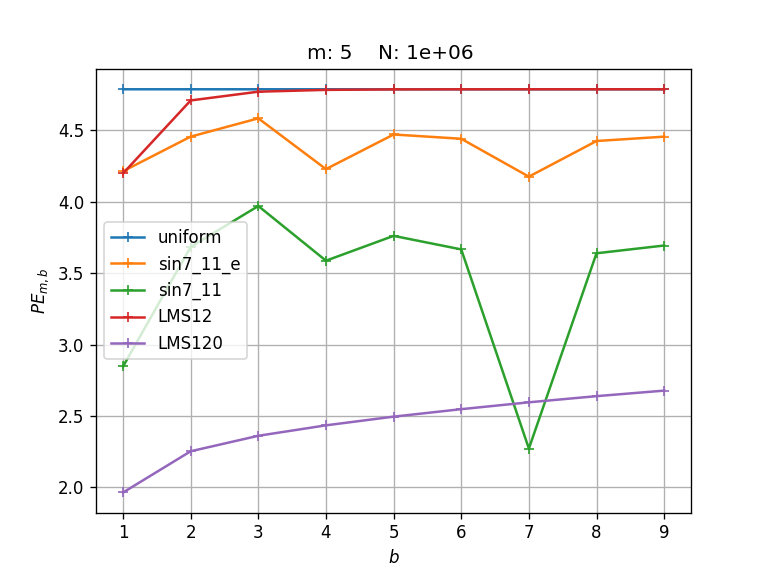

In [ ]:
mn=float('inf')
mx=-float('inf')
m=5
for serie in name_serie:
    
   
    
    sec=select([('serie',serie),('m',m)],lms)
    sec=sec[sec['N']>9.9e5]
    X=sec['b']
    mn=min(mn,X.min())
    mx=max(mx,X.max())
    y=sec['PE']
    #color=['red','green','blue'][int(m/4)-1]
    
    plt.plot((X),(y),marker='+')
    


plt.xlabel('$b$')
#plt.xscale('log')
plt.ylabel('$PE_{m,b}$')
#plt.yscale('log')
plt.legend(name_serie)
plt.title('m: %i    N: %g ' % (m,round(sec['N'].max())))

plt.grid()

plt.show()




In [ ]:
with open('exper2_b.pkl','rb') as fich:
    lms = pickle.load(fich)

In [ ]:
lms.serie.unique()

array(['uniform', 'sin7_11_e', 'sin7_11', 'LMS12', 'LMS120'], dtype=object)

In [ ]:
lms.describe()

,N,b,m,PE,N/m!,t,H
count,2500.0,2500.000000,2500.0,2500.000000,2.500000e+03,2500.000000,2500.000000
mean,1000000.0,500.000000,5.0,3.992839,8.333333e+03,1.663741,0.794652
std,0.0,288.732309,0.0,0.897695,1.819353e-12,0.063397,0.897695
min,1000000.0,1.000000,5.0,1.945910,8.333333e+03,1.514688,0.000034
25%,1000000.0,250.500000,5.0,3.015648,8.333333e+03,1.621092,0.000061
50%,1000000.0,500.000000,5.0,4.425885,8.333333e+03,1.667643,0.361607
75%,1000000.0,749.500000,5.0,4.787431,8.333333e+03,1.700212,1.771844
max,1000000.0,999.000000,5.0,4.787458,8.333333e+03,3.481555,2.841582


<IPython.core.display.Javascript object>


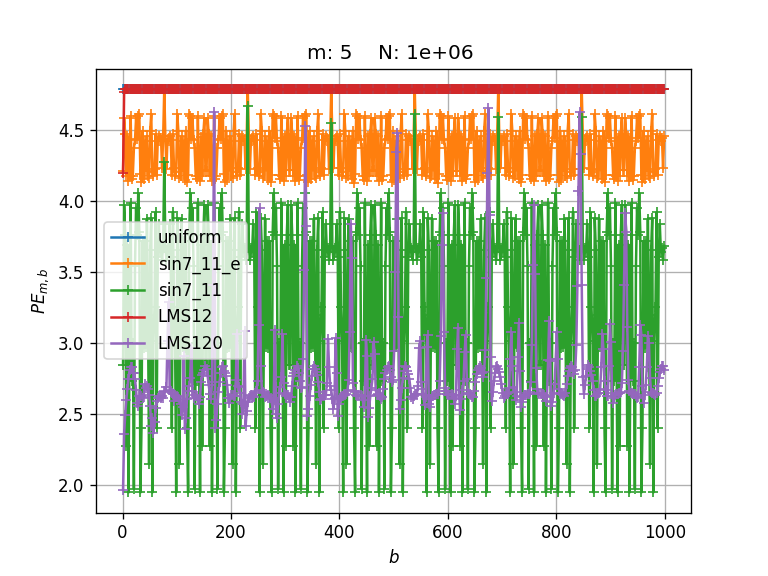

In [ ]:
mn=float('inf')
mx=-float('inf')
m=5
for serie in name_serie:
    
   
    
    sec=select([('serie',serie),('m',m)],lms)
    sec=sec[sec['N']>9.9e5]
    X=sec['b']
    mn=min(mn,X.min())
    mx=max(mx,X.max())
    y=sec['PE']
    #color=['red','green','blue'][int(m/4)-1]
    
    plt.plot((X),(y),marker='+')
    


plt.xlabel('$b$')
#plt.xscale('log')
plt.ylabel('$PE_{m,b}$')
#plt.yscale('log')
plt.legend(name_serie)
plt.title('m: %i    N: %g ' % (m,round(sec['N'].max())))

plt.grid()

plt.show()



exper3_b=simulation(series,name_serie,[1e6],[8],range(1,1000,2))

with open('exper3_b.pkl','wb') as fich:
    pickle.dump(exper3_b,fich)

In [ ]:
with open('exper3_b.pkl','rb') as fich:
    lms = pickle.load(fich)

<IPython.core.display.Javascript object>


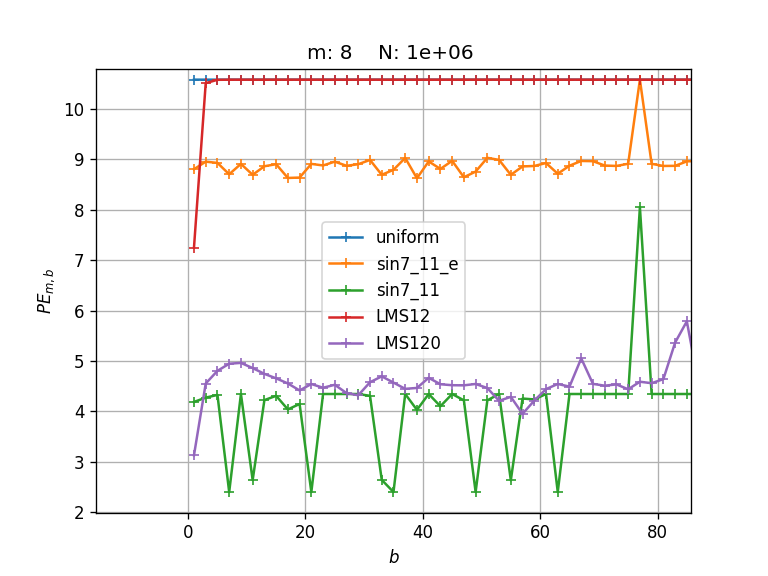

In [ ]:
mn=float('inf')
mx=-float('inf')
m=8
for serie in name_serie:
    
   
    
    sec=select([('serie',serie),('m',m)],lms)
    #sec=sec[sec['N']>9.9e5]
    X=sec['b']
    mn=min(mn,X.min())
    mx=max(mx,X.max())
    y=sec['PE']
    #color=['red','green','blue'][int(m/4)-1]
    
    plt.plot((X),(y),marker='+')
    


plt.xlabel('$b$')
#plt.xscale('log')
plt.ylabel('$PE_{m,b}$')
#plt.yscale('log')
plt.legend(name_serie)
plt.title('m: %i    N: %g ' % (m,round(sec['N'].max())))

plt.grid()

plt.show()

